In [22]:
###Import the usual libraries
import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord

import sklearn
import hdbscan
import sklearn.cluster as skc

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 24}) #make plots more readable

import MagellanicStream as ms
import astropy.units as u
from astropy.coordinates import SkyCoord
from uncertainties import ufloat

import warnings
warnings.filterwarnings('ignore')

import galpy as gp
from galpy.potential import MWPotential2014, plotPotentials, plotDensities, plotRotcurve, MiyamotoNagaiPotential
from galpy.orbit import Orbit

In [23]:
###Import Data to cluster
monarch = fits.getdata('/Users/joshpovick/Desktop/Research/MS_young/monarch.fits')
monarch = Table(monarch)

###Import Data for velcoity plot
bstpath = '/Users/joshpovick/Desktop/Research/fits/bstars.fits' #original icr stars fits
duppath = '/Users/joshpovick/Desktop/Research/fits/final_dupont_oct09.fits' #original dupont stars
lmcpath = '/Users/joshpovick/Desktop/Research/fits/figure_data_bstars/icstars_lmc_vlsrmlon_lines.fits' #lmc velocity
msvpath = '/Users/joshpovick/Desktop/Research/fits/figure_data_bstars/icstars_hivlsrmlon_lines.fits' #ms velocity
bacpath = '/Users/joshpovick/Desktop/Research/fits/figure_data_bstars/icstars_hivlsrmlon.fits' #HI background

bstars = fits.getdata(bstpath,1)
dupont = fits.getdata(duppath,1)
backgd = fits.getdata(bacpath,1)
lmcvel = fits.getdata(lmcpath,1)
msvelo = fits.getdata(msvpath,1)

In [199]:
#User defined functions

def dup(data):
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

def absmags(magnitude,distance,parallax):
    absm = []
    if (parallax == True):
        dist = np.reciprocal(distance)*1000
        absm.append(magnitude-5.0*np.log10(dist)+5.0)
        absm = np.squeeze(np.array(absm))
    elif (parallax == False):
        absm.append(magnitude-5.0*np.log10(distance)+5.0)
        absm = np.squeeze(np.array(absm))
    return absm

# def galxyz(distance,mlon,mlat,parallax):
#     galx = []
#     galy = []
#     galz = []
#     if (parallax == True):
#         d = np.reciprocal(distance)*1000
#         galx.append(8.3 - d*np.cos(mlat)*np.cos(mlon))
#         galy.append(d*np.cos(mlat)*np.sin(mlon))
#         galz.append(d*np.sin(mlat))
#         galx = np.squeeze(galx)
#         galy = np.squeeze(galy)
#         galz = np.squeeze(galz)
#     elif (parallax == False):
#         d = distance
#         galx.append(8.3 - d*np.cos(mlat)*np.cos(mlon))
#         galy.append(d*np.cos(mlat)*np.sin(mlon))
#         galz.append(d*np.sin(mlat))
#         galx = np.squeeze(galx)
#         galy = np.squeeze(galy)
#         galz = np.squeeze(galz)
#     return galx, galy, galz

# def galvelxyz():
#     a = [[np.cos(),np.sin(),0],[np.sin(),-np.cos(),0],[0,0,1]]
#     b = [[-np.sin(),,],[,,],[,,]]
#     c = [[,,],[,,],[,,]]

def gal6d(ra,dec,parallax,vrad,pmra,pmdec):
    '''Right handed coordinates using J2000 for constants'''
    th0 = 123.0 #Johnson, Dean R. H., Sonderblom, David R. 1987
    decNGP = 27.13
    raNGP = 192.85
    k = 4.74057 #Johnson, Dean R. H., Sonderblom, David R. 1987
    d = np.reciprocal(parallax)
    galx = []
    galy = []
    galz = []
    galvx = []
    galvy = []
    galvz = []
    galcoor = []
    
    ta = [[np.cos(th0),np.sin(th0),0],[np.sin(th0),-np.cos(th0),0],[0,0,1]]
    tb = [[-np.sin(decNGP),0,np.cos(decNGP)],[0,-1,0],[np.cos(decNGP),0,np.sin(decNGP)]]
    tc = [[np.cos(raNGP),np.sin(raNGP),0],[np.sin(raNGP),-np.cos(raNGP),0],[0,0,1]]
    t = np.linalg.multi_dot([ta,tb,tc])
    
    aa = [[np.cos(ra),np.sin(ra),0],[np.sin(ra),-np.cos(ra),0],[0,0,-1]]
    ab = [[np.cos(ra),0,-np.sin(ra)],[0,-1,0],[-np.sin(ra),0,-np.cos(ra)]]
    b = np.linalg.multi_dot([aa,ab])
    
    #get position
    pos = d*np.dot(t,[np.cos(dec)*np.cos(ra),np.cos(dec)*np.sin(ra),np.sin(dec)])
    for i in range(len(pos)):
        pos[0] = 8.3 - pos[0]
    #get velocities
    vel = np.dot(b,[vrad,k*pmra*d,k*pmdec*d])
    for j in range(len(vel)): #Mihalas and Routly 1968
        vel[0] = 10.4 - vel[0] 
        vel[1] = 15.0 - vel[1]
        vel[2] = 7.50 - vel[2] 
    
    galcoor.append([pos,vel])
    galcoor = np.squeeze(galcoor)
    
    return galcoor

[[  -3.93312248   -1.26528775   -5.69722614]
 [ 237.60763323  -20.67780209 -185.69210304]]


2

In [25]:
###Cluster Data
usurper = np.array([monarch['pmra'],monarch['pmdec'],monarch['parallax']+0.052,monarch['VLSR'],monarch['MLON']]).T

#hdbscan
clustererhdbscan = hdbscan.HDBSCAN(metric='euclidean',min_samples=1,cluster_selection_method='leaf')
clustererhdbscan.fit(usurper)
colhdbscan = clustererhdbscan.labels_

#spectral clustering
clustererspectral = skc.SpectralClustering(n_clusters=50,assign_labels='discretize',random_state=0,n_init=100)
clustererspectral.fit(usurper)
colspectral = clustererspectral.labels_

#k means 
clustererkmeans = skc.KMeans(n_clusters=60, random_state=0)
clustererkmeans.fit(usurper)
colkmeans = clustererkmeans.labels_


In [26]:
#convert to galactocentric coordinates (x,y,z) and get galactocentric velocities and angular momentum
from astropy.coordinates import Distance

galact = []
for i in range(len(monarch)):
    cr = coord.ICRS(ra=monarch['RA'][i]*u.degree, dec=monarch['DEC'][i]*u.degree, \
                        distance=Distance(parallax=(monarch['parallax'][i]+0.03)*u.mas,allow_negative=True),\
                        pm_ra_cosdec=monarch['pmra'][i]*u.mas/u.yr,\
                        pm_dec=monarch['pmdec'][i]*u.mas/u.yr,
                        radial_velocity=monarch['VLSR'][i]*u.km/u.s)
    gcoor = cr.transform_to(coord.Galactocentric)
    galact.append(gcoor)
    
#Extract velocities  
xvel = []
yvel = []
zvel = []

for i in range(len(galact)):
    xvel.append((galact[i].v_x).value)
    yvel.append((galact[i].v_y).value)
    zvel.append((galact[i].v_z).value)
    
xvel=np.squeeze(xvel)
yvel=np.squeeze(yvel)
zvel=np.squeeze(zvel)

#Extract position
xpos = []
ypos = []
zpos = []

for i in range(len(galact)):
    xpos.append((galact[i].x).value*1/1000.) #note conversion from pc to kpc
    ypos.append((galact[i].y).value*1/1000.)
    zpos.append((galact[i].z).value*1/1000.)
    
xpos=np.squeeze(xpos)
ypos=np.squeeze(ypos)
zpos=np.squeeze(zpos)

#Calculate Angular momentum
s = []
sx = []
sy = []
sz = []
for i in range(len(galact)):
    radius = [xpos[i],ypos[i],zpos[i]]
    velocity = [xvel[i],yvel[i],zvel[i]]
    s.append(np.cross(radius,velocity))
    sx.append(s[i][0])
    sy.append(s[i][1])
    sz.append(s[i][2])

In [158]:
print(galact[1])

<Galactocentric Coordinate (galcen_coord=<ICRS Coordinate: (ra, dec) in deg
    (266.4051, -28.936175)>, galcen_distance=8.3 kpc, galcen_v_sun=(11.1, 232.24, 7.25) km / s, z_sun=27.0 pc, roll=0.0 deg): (x, y, z) in pc
    (-7113.55420511, -3044.04518637, -2579.93661374)
 (v_x, v_y, v_z) in km / s
    (-18.28252305, 82.40222815, 17.01728665)>


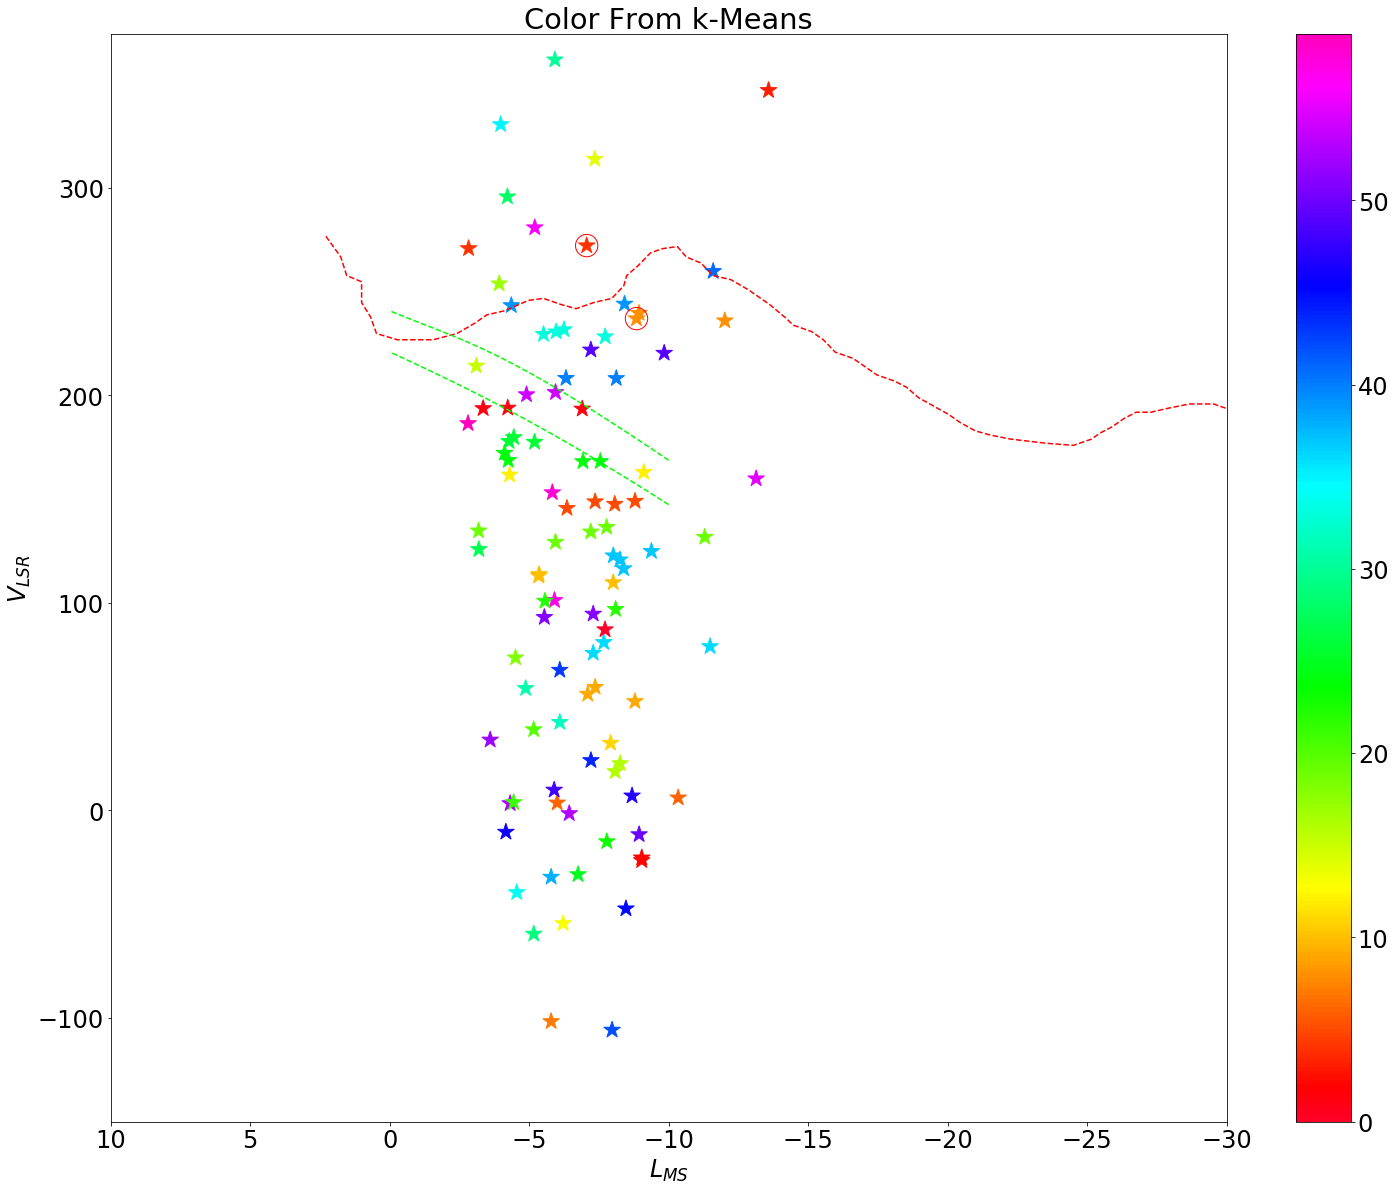

In [27]:
#Clustering
di15 = np.where(monarch['NAME']=='DI1507')
di14 = np.where(monarch['NAME']=='DI1450')
cpos = np.append(monarch[di15]['MLON'],monarch[di14]['MLON'])
cvel = np.append(monarch[di15]['VLSR'],monarch[di14]['VLSR'])

#HI background
xarr,yarr=np.meshgrid(backgd['XARR'][0],backgd['YARR'][0])
z=backgd['IM'][0]

'''plot with |\mu|'''
fig = plt.figure(figsize=(25,20))
plt.xlim(-30,10)
plt.ylim(-150,374)
plt.gca().invert_xaxis()
#pcm = plt.pcolormesh(xarr, yarr, z, cmap='jet',shading='gouraud') #generate background

plt.plot(msvelo[0][0],msvelo[0][1],'r--',label='LMC filament')
plt.plot(lmcvel[0][0],lmcvel[0][1],c='lime',linestyle='dashed',label='LMC velocity')
plt.plot(lmcvel[0][2],lmcvel[0][3],c='lime',linestyle='dashed')

plt.scatter(monarch['MLON'],monarch['VLSR'],c=colkmeans,marker='*',s=300,label='ICR Stars',cmap='gist_rainbow')

plt.colorbar()
plt.scatter(cpos,cvel,facecolors='none',edgecolors='r',s=500,label='YMSC')

plt.ylabel(r'$V_{LSR}$')
plt.xlabel(r'$L_{MS}$')
plt.title(r'Color From k-Means')
plt.savefig('velopos.pdf',bbox_inches='tight')
plt.show()

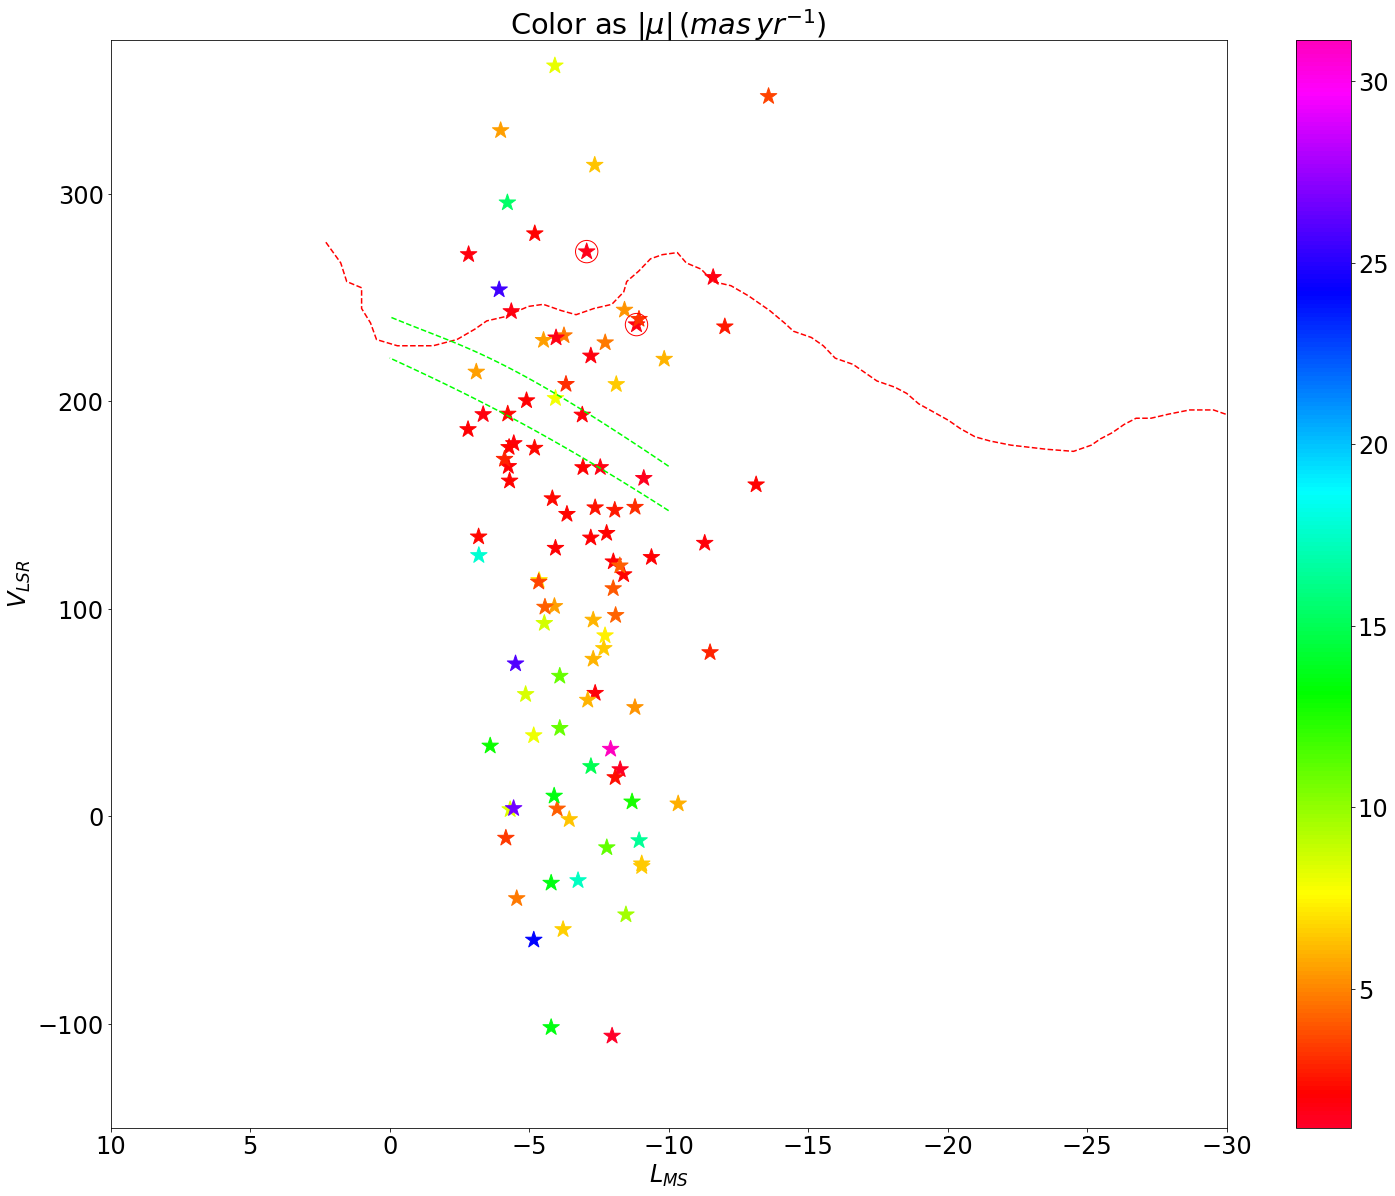

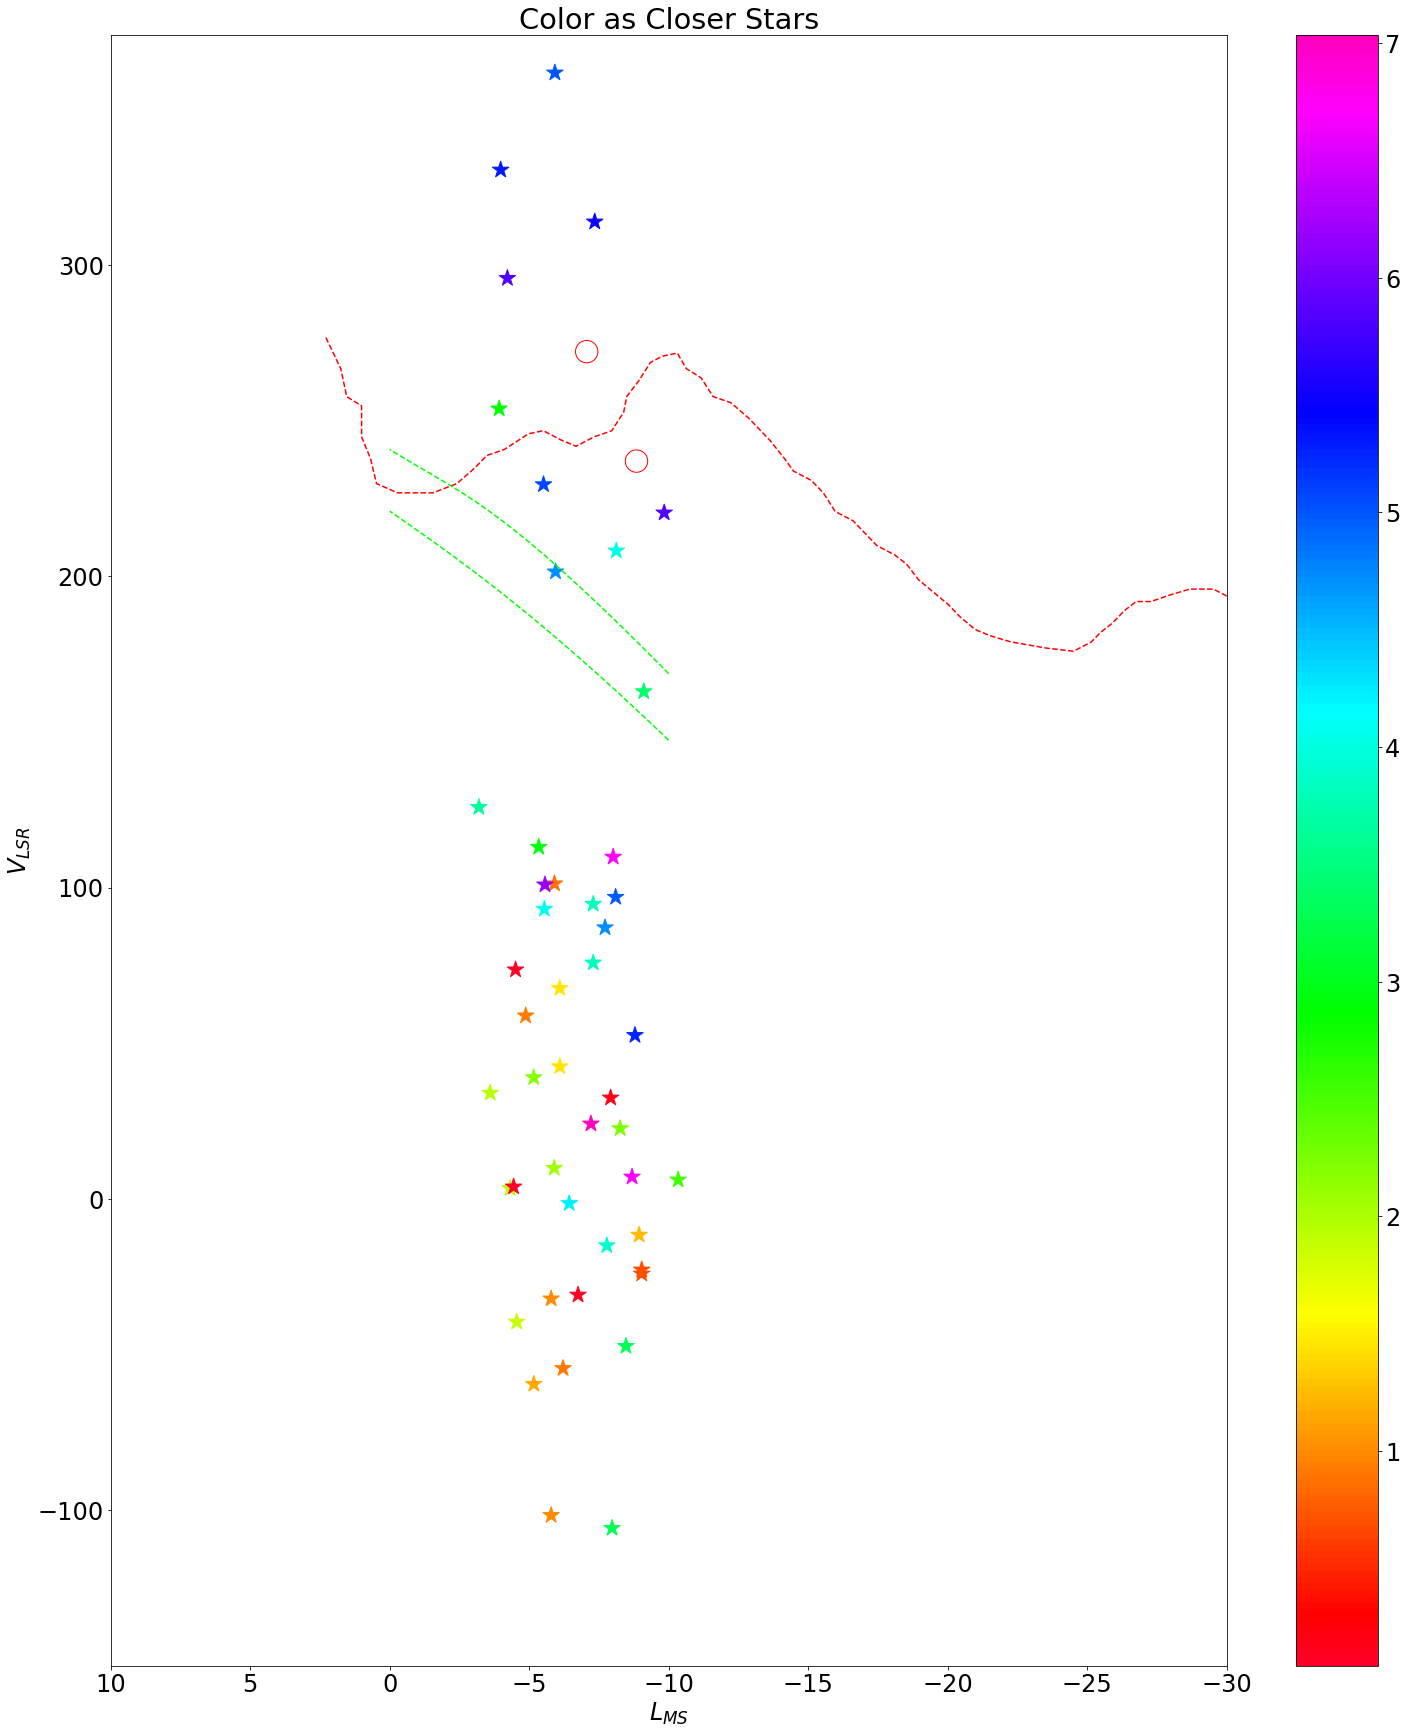

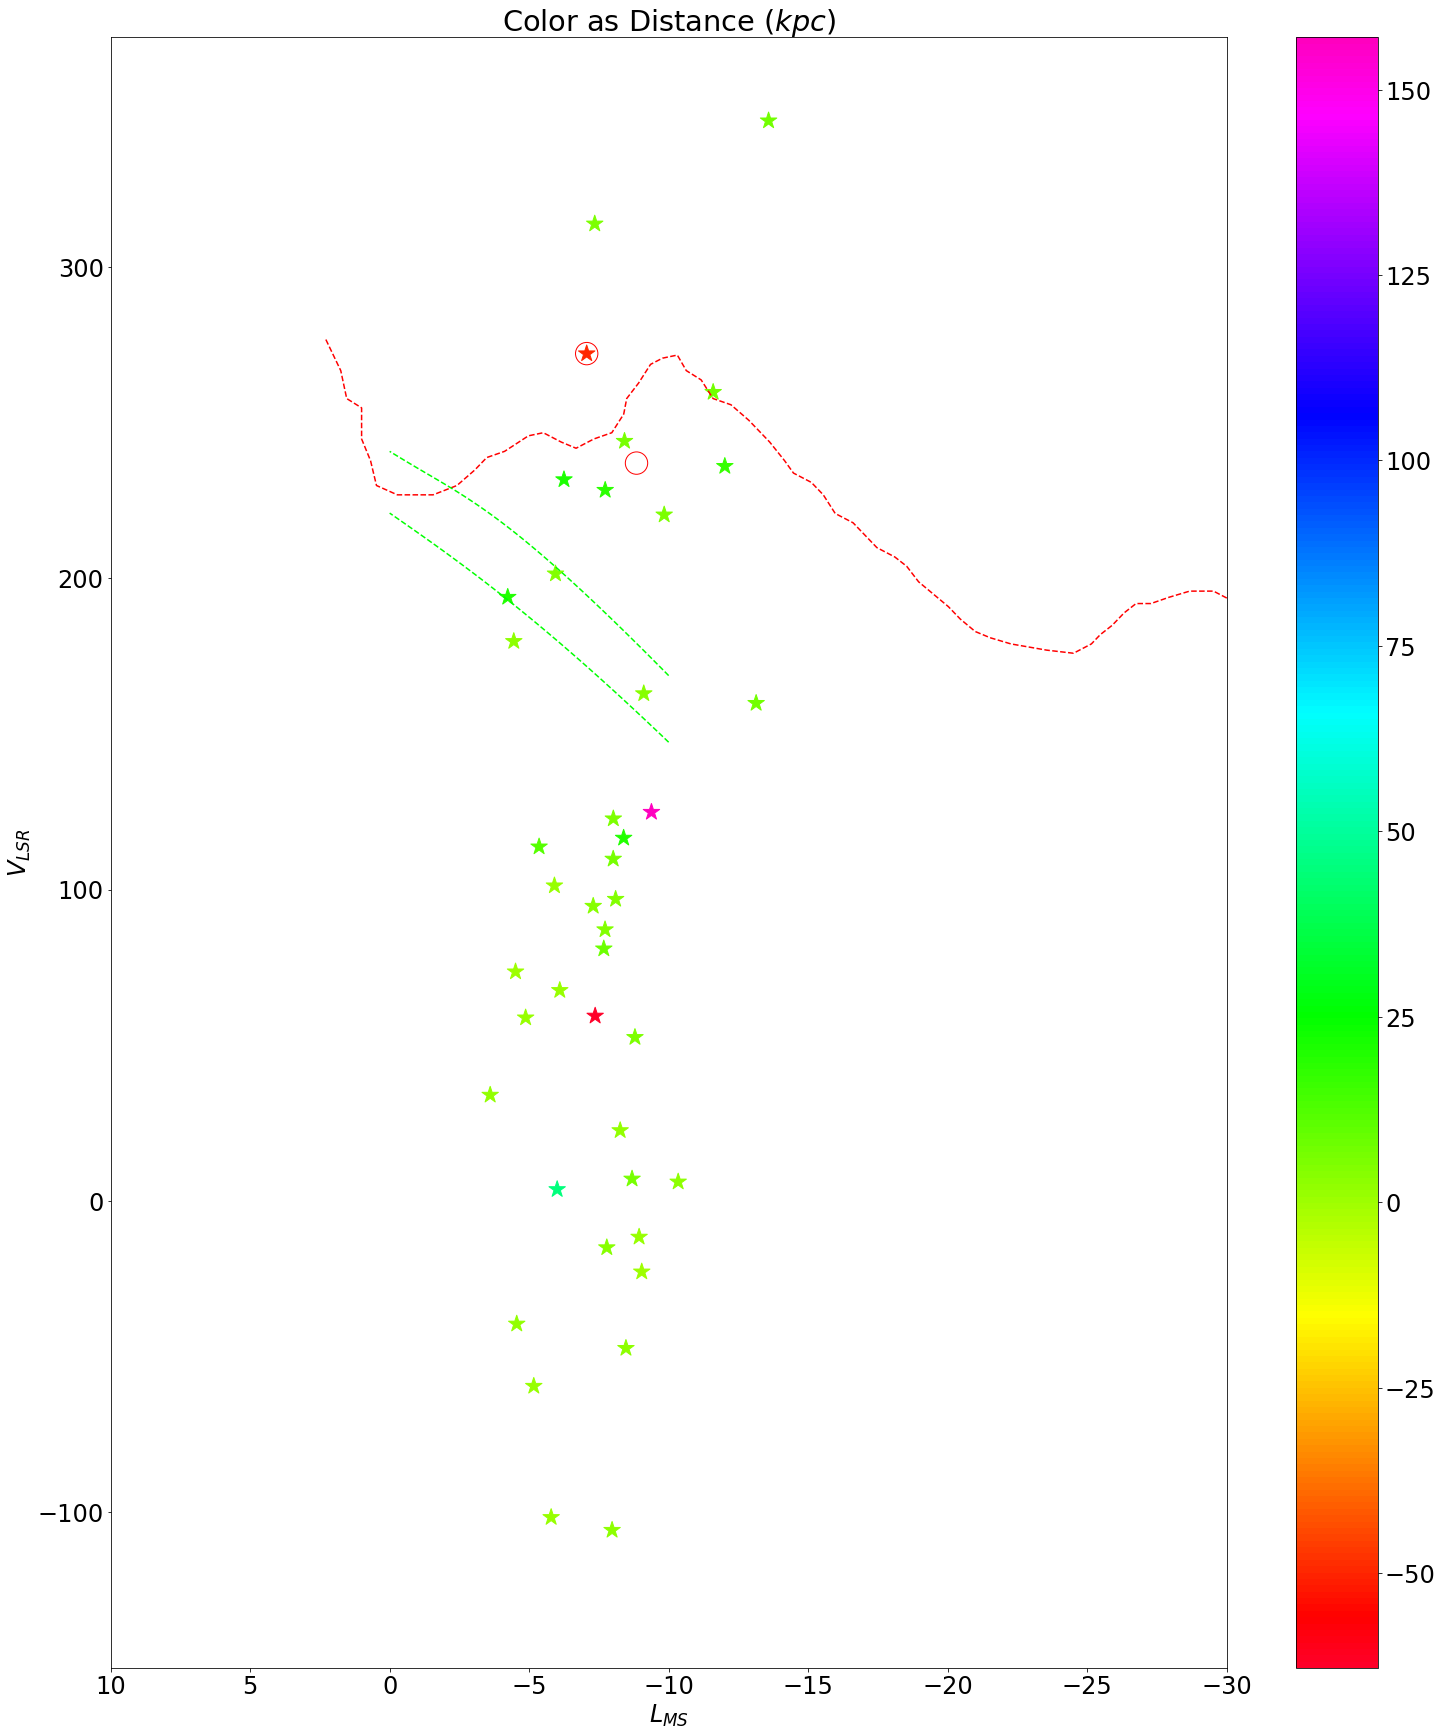

In [28]:
### Velocity Postion plot
#candidate young stars
di15 = np.where(monarch['NAME']=='DI1507')
di14 = np.where(monarch['NAME']=='DI1450')
cpos = np.append(monarch[di15]['MLON'],monarch[di14]['MLON'])
cvel = np.append(monarch[di15]['VLSR'],monarch[di14]['VLSR'])

#HI background
xarr,yarr=np.meshgrid(backgd['XARR'][0],backgd['YARR'][0])
z=backgd['IM'][0]

'''plot with |\mu|'''
fig = plt.figure(figsize=(25,20))
plt.xlim(-30,10)
plt.ylim(-150,374)
plt.gca().invert_xaxis()
#pcm = plt.pcolormesh(xarr, yarr, z, cmap='jet',shading='gouraud') #generate background

plt.plot(msvelo[0][0],msvelo[0][1],'r--',label='LMC filament')
plt.plot(lmcvel[0][0],lmcvel[0][1],c='lime',linestyle='dashed',label='LMC velocity')
plt.plot(lmcvel[0][2],lmcvel[0][3],c='lime',linestyle='dashed')

plt.scatter(monarch['MLON'],monarch['VLSR'],c=np.sqrt(monarch['pmra']**2+monarch['pmdec']**2),marker='*',s=300,label='ICR Stars',cmap='gist_rainbow')

plt.colorbar()
plt.scatter(cpos,cvel,facecolors='none',edgecolors='r',s=500,label='YMSC')

plt.ylabel(r'$V_{LSR}$')
plt.xlabel(r'$L_{MS}$')
plt.title(r'Color as $|\mu|\,(mas\,yr^{-1})$')
plt.savefig('velopos.pdf',bbox_inches='tight')
plt.show()

'''plot with closer stars'''
plt.figure(figsize=(25,30))
paracut = np.reciprocal(monarch['parallax']+0.052)
closer = np.where((monarch['parallax_over_error']>=3)&(monarch['parallax']>0))
farther = np.delete(range(len(monarch)),closer)
plt.xlim(-30,10)
plt.ylim(-150,374)
plt.gca().invert_xaxis()
#pcm = plt.pcolormesh(xarr, yarr, z, cmap='jet',shading='gouraud') #generate background

plt.plot(msvelo[0][0],msvelo[0][1],'r--',label='LMC filament')
plt.plot(lmcvel[0][0],lmcvel[0][1],c='lime',linestyle='dashed',label='LMC velocity')
plt.plot(lmcvel[0][2],lmcvel[0][3],c='lime',linestyle='dashed')

plt.scatter(monarch[closer]['MLON'],monarch[closer]['VLSR'],c=np.reciprocal(monarch[closer]['parallax']+0.052),marker='*',s=300,label='ICR Stars',cmap='gist_rainbow')

plt.colorbar()
plt.scatter(cpos,cvel,facecolors='none',edgecolors='r',s=500,label='YMSC')

plt.ylabel(r'$V_{LSR}$')
plt.xlabel(r'$L_{MS}$')
plt.title(r'Color as Closer Stars')
plt.savefig('velopos.pdf',bbox_inches='tight')
plt.show()

'''plot with farther stars'''
plt.figure(figsize=(25,30))
paracut = np.reciprocal(monarch['parallax']+0.052)
closer = np.where((monarch['parallax_over_error']>=3)&(monarch['parallax']>0))
farther = np.delete(range(len(monarch)),closer)
farther_2 = np.where((np.reciprocal(monarch[farther]['parallax']+0.052)>-50)&(np.reciprocal(monarch[farther]['parallax']+0.052)<50))
plt.xlim(-30,10)
plt.ylim(-150,374)
plt.gca().invert_xaxis()
#pcm = plt.pcolormesh(xarr, yarr, z, cmap='jet',shading='gouraud') #generate background

plt.plot(msvelo[0][0],msvelo[0][1],'r--',label='LMC filament')
plt.plot(lmcvel[0][0],lmcvel[0][1],c='lime',linestyle='dashed',label='LMC velocity')
plt.plot(lmcvel[0][2],lmcvel[0][3],c='lime',linestyle='dashed')

plt.scatter(monarch[farther_2]['MLON'],monarch[farther_2]['VLSR'],c=np.reciprocal(monarch[farther_2]['parallax']+0.052),marker='*',s=300,label='ICR Stars',cmap='gist_rainbow')

plt.colorbar()
plt.scatter(cpos,cvel,facecolors='none',edgecolors='r',s=500,label='YMSC')

plt.ylabel(r'$V_{LSR}$')
plt.xlabel(r'$L_{MS}$')
plt.title(r'Color as Distance $(kpc)$')
plt.savefig('velopos.pdf',bbox_inches='tight')
plt.show()


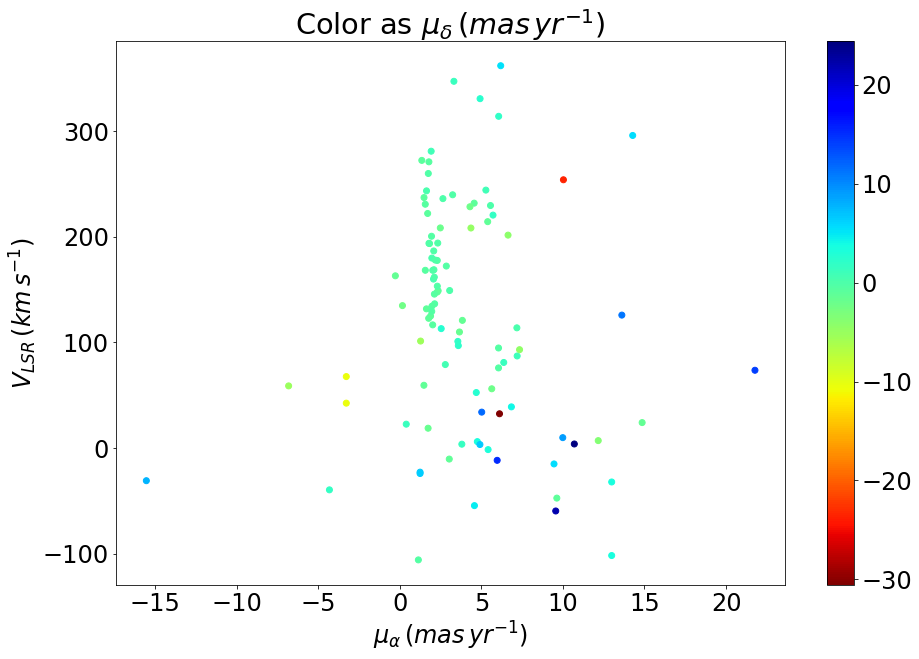

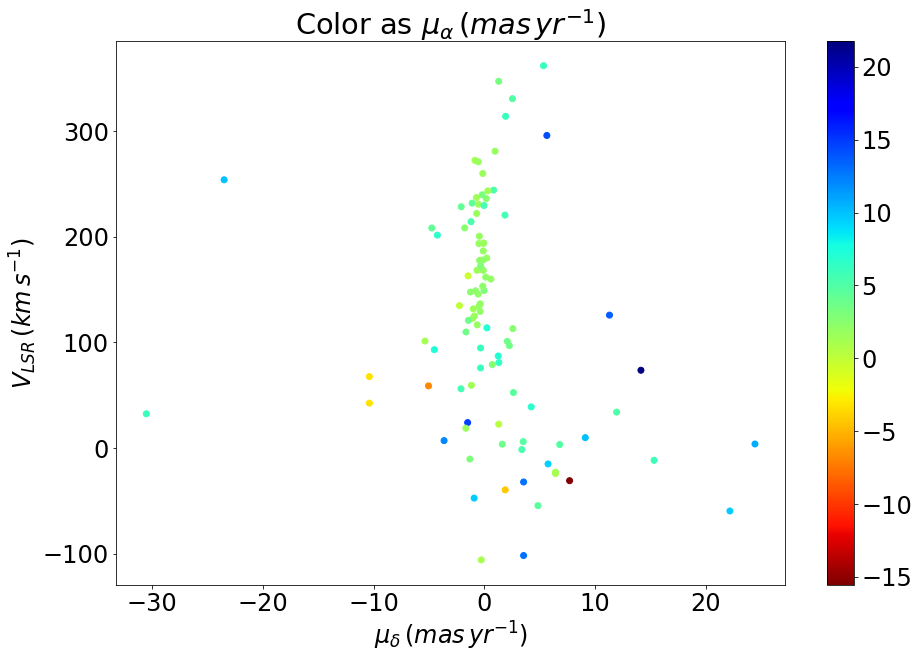

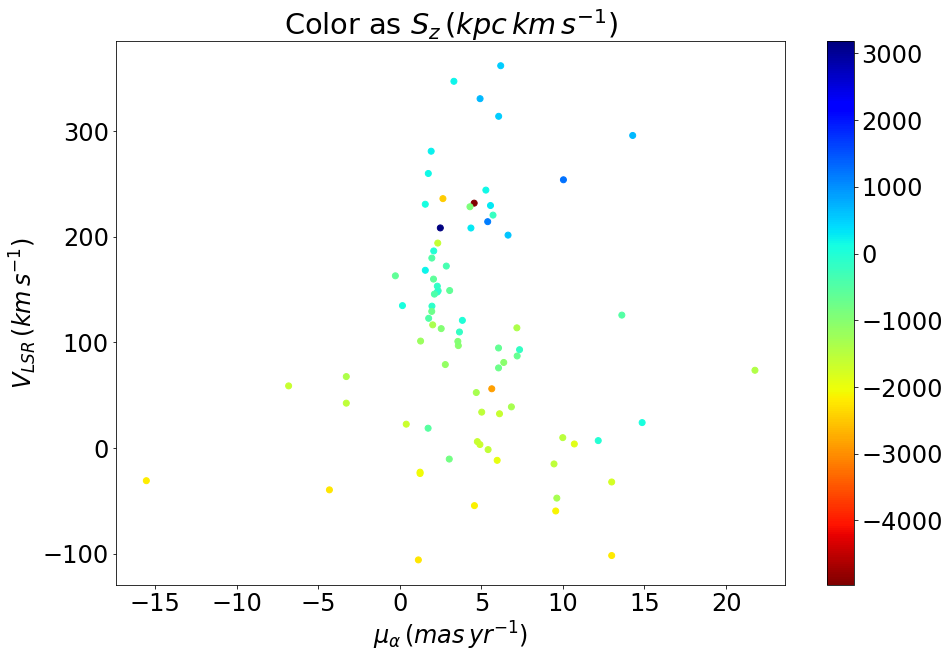

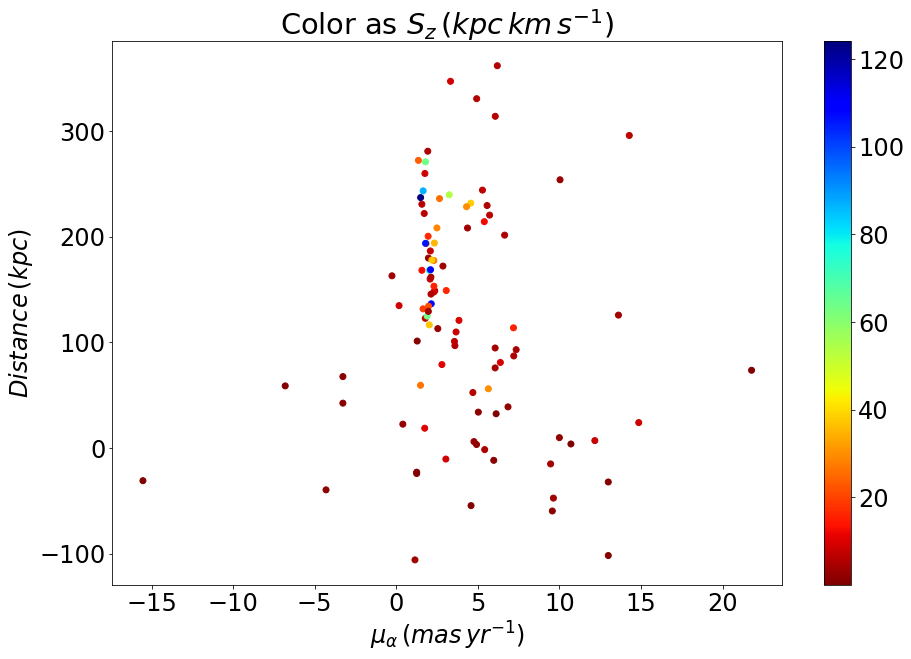

In [29]:
###Proper Motion VLSR
plt.figure(figsize=(15,10))
plt.scatter(monarch['pmra'],monarch['VLSR'],c=monarch['pmdec'],cmap='jet_r')
plt.title(r'Color as $\mu_{\delta}\,(mas\,yr^{-1})$')
plt.xlabel(r'$\mu_{\alpha}\,(mas\,yr^{-1})$')
plt.ylabel(r'$V_{LSR}\,(km\,s^{-1})$')
plt.colorbar()
plt.show()

plt.figure(figsize=(15,10))
plt.scatter(monarch['pmdec'],monarch['VLSR'],c=monarch['pmra'],cmap='jet_r')
plt.title(r'Color as $\mu_{\alpha}\,(mas\,yr^{-1})$')
plt.xlabel(r'$\mu_{\delta}\,(mas\,yr^{-1})$')
plt.ylabel(r'$V_{LSR}\,(km\,s^{-1})$')
plt.colorbar()
plt.show()

slim = -5000
mod_sz = []
for i in range(len(sz)):
    if (sz[i]>=slim):
        mod_sz.append(i)

new_pmra = []
new_vlsr = []
new_sz = []
dist_test = []
for j in mod_sz:
    new_pmra.append(monarch['pmra'][j])
    new_vlsr.append(monarch['VLSR'][j])
    new_sz.append(sz[j])
    dist_test.append(np.reciprocal(monarch['parallax'][j]+0.03))
    
plt.figure(figsize=(15,10))
plt.scatter(new_pmra,new_vlsr,c=new_sz,cmap='jet_r')
plt.title(r'Color as $S_{z}\,(kpc\,km\,s^{-1})$')
plt.xlabel(r'$\mu_{\alpha}\,(mas\,yr^{-1})$')
plt.ylabel(r'$V_{LSR}\,(km\,s^{-1})$')
plt.colorbar()
plt.show()

good = np.where((np.reciprocal(monarch['parallax']+0.03)<=500))
good2 = np.squeeze(good)
dist = []
for k in good2:
    dist.append(np.reciprocal(monarch['parallax'][k]+0.03))

plt.figure(figsize=(15,10))
# plt.scatter(new_pmra,new_vlsr,c=dist_test,cmap='jet_r')
plt.scatter(monarch[good]['pmra'],monarch[good]['VLSR'],c=np.absolute(dist),cmap='jet_r')
plt.title(r'Color as $S_{z}\,(kpc\,km\,s^{-1})$')
plt.xlabel(r'$\mu_{\alpha}\,(mas\,yr^{-1})$')
plt.ylabel(r'$Distance\,(kpc)$')
plt.colorbar()
plt.show()

In [82]:
### import data and calculate desnity for HR Diagram
allicr = fits.getdata('/Users/joshpovick/Desktop/Research/fits/allICR-result.fits',1)
from scipy.stats import binned_statistic_2d

# #covert to absolute mag
# absGmon = []
# d1 = np.reciprocal(monarch['parallax']+0.03)*1000
# for i in range(len(monarch)):
#     absGmon.append(monarch['phot_g_mean_mag'][i]-5*np.log10(d1[i])+5)

# absGicr = []
# d2 = np.reciprocal(allicr['parallax']+0.03)*1000
# for i in range(len(allicr)):
#     absGicr.append(allicr['phot_g_mean_mag'][i]-5*np.log10(d2[i])+5)
    
# #Calculate Star Density
# cln = np.where((np.isfinite(allicr['bp_rp'])==True) & (np.isfinite(absGicr)==True))
# clean_icr = allicr[cln]

# clean_absGallicr = []
# for i in np.squeeze(cln):
#     clean_absGallicr.append(absGicr[i])
    
# perrcut = np.where(clean_icr['parallax_over_error']>=4)
# cleaner_icr = clean_icr[perrcut]

# cleaner_absGallicr = []
# for i in np.squeeze(perrcut):
#     cleaner_absGallicr.append(clean_absGallicr[i])

### Absolute magnitudes for ICR and Gaia
gaiaAbsG = np.squeeze(absmags(allicr['phot_g_mean_mag'],allicr['parallax']+0.03,True))
monarchAbsG = np.squeeze(absmags(monarch['phot_g_mean_mag'],monarch['parallax']+0.03,True))

clng = np.where((np.isfinite(allicr['bp_rp'])==True)&(np.isfinite(np.squeeze(gaiaAbsG))==True)&(allicr['parallax_over_error']>=4))
cleangaia = allicr[clng]

clni = np.where((np.isfinite(monarch['bp_rp'])==True)&(np.isfinite(np.squeeze(monarchAbsG))==True)&(monarch['parallax_over_error']>=4))
cleanicr = monarch[clni]
cleanmonAbsG = monarchAbsG[clni]

icrhess = binned_statistic_2d(cleangaia['bp_rp'], gaiaAbsG[clng], None,'count',bins=300)

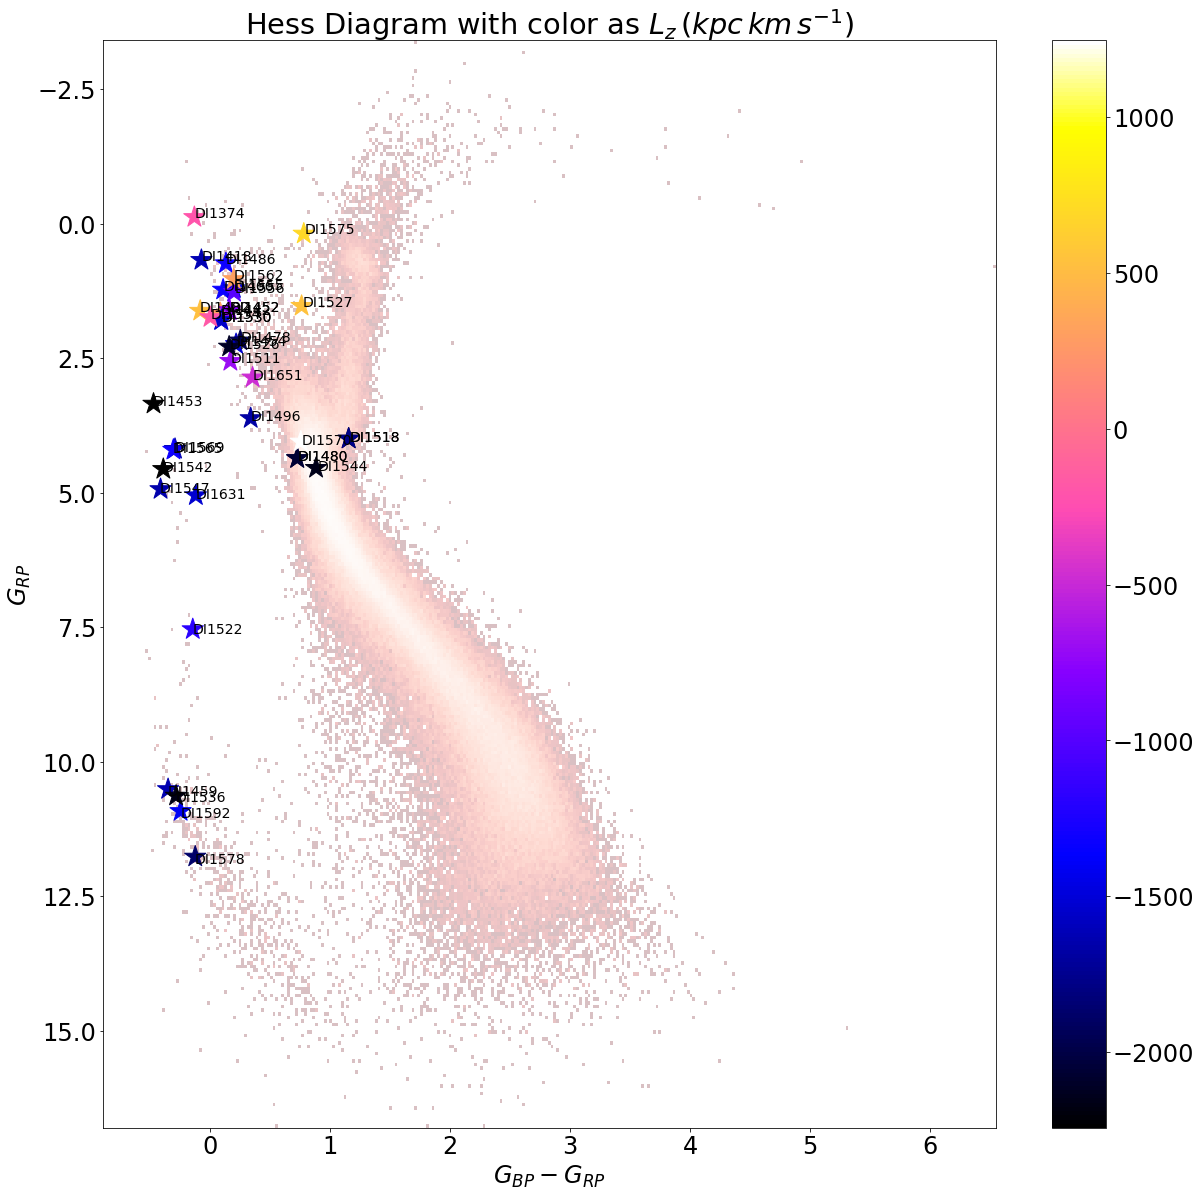

In [134]:
###Calculate HR Diaggram

closeangmo = []
for i in np.squeeze(clni):
    closeangmo.append(sz[i])
   
import matplotlib.cm as cm
cmap1 = cm.get_cmap('Reds_r')
plt.figure(figsize=[20,20])
plt.imshow(np.log10(icrhess.statistic.T), origin='lower',extent=[icrhess.x_edge[0], icrhess.x_edge[-1], icrhess.y_edge[0], icrhess.y_edge[-1]],aspect='auto', interpolation='nearest', cmap=cmap1,alpha=0.25)
plt.scatter(cleanicr['bp_rp'],cleanmonAbsG,marker='*',c=closeangmo,s=500,cmap='gnuplot2')
plt.colorbar()
plt.gca().invert_yaxis()
plt.xlabel(r'$G_{BP}-G_{RP}$')
plt.ylabel(r'$G_{RP}$')
plt.title(r'Hess Diagram with color as $L_{z}\,(kpc\,km\,s^{-1})$')
for j in range(len(cleanicr)):
    plt.text(cleanicr['bp_rp'][j]*(1.0+0.01),cleanmonAbsG[j]*(1.0+0.01),cleanicr['NAME'][j],fontsize=14)
plt.savefig('icrhess.pdf',bbox_inches='tight')
plt.show()

In [112]:
### Possible Moving Groups
'''
DI1562 DI1374 DI1665 DI1488 DI1497 DI1453 DI1442 DI1499

DI1567 DI1020 DI1482 DI1527
'''

move1 = [] 
move2 = []
for i in range(len(monarch)):
    if (monarch['NAME'][i]=='DI1562' or monarch['NAME'][i]=='DI1374' or monarch['NAME'][i]=='DI1665' or monarch['NAME'][i]=='DI1488' or monarch['NAME'][i]=='DI1497' or monarch['NAME'][i]=='DI1435' or monarch['NAME'][i]=='DI1442' or monarch['NAME'][i]=='DI1499'):
        move1.append(i)
    elif (monarch['NAME'][i]=='DI1567' or monarch['NAME'][i]=='DI1020' or monarch['NAME'][i]=='DI1482' or monarch['NAME'][i]=='DI1527' or monarch['NAME'][i]=='DI1575' or monarch['NAME'][i]=='DI1523'):
        move2.append(i)

x1 = []
y1 = []
z1 = []
xv1 = []
yv1 = []
zv1 = []
for j in move1:
    x1.append(xpos[j])
    y1.append(ypos[j])
    z1.append(zpos[j])
    xv1.append(xvel[j])
    yv1.append(yvel[j])
    zv1.append(zvel[j])

x2 = []
y2 = []
z2 = []
xv2 = []
yv2 = []
zv2 = []
for k in move2:
    x2.append(xpos[k])
    y2.append(ypos[k])
    z2.append(zpos[k])
    xv2.append(xvel[k])
    yv2.append(yvel[k])
    zv2.append(zvel[k])
    
group1 = monarch[move1]
group1['xpos'] = x1
group1['ypos'] = y1
group1['zpos'] = z1 
group1['xvel'] = xv1
group1['yvel'] = yv1
group1['zvel'] = zv1

group2 = monarch[move2]
group2['xpos'] = x2
group2['ypos'] = y2
group2['zpos'] = z2 
group2['xvel'] = xv2
group2['yvel'] = yv2
group2['zvel'] = zv2
    

In [113]:
###angular momentum for possible moving groups
s1 = []
s1z = []
for i in range(len(group1)):
    r = [group1['xpos'][i],group1['ypos'][i],group1['zpos'][i]]
    v = [group1['xvel'][i],group1['yvel'][i],group1['zvel'][i]]
    s1.append(np.cross(r,v))
    s1z.append(s1[i][2])
group1['ang'] = s1
    
s2 = []
s2z = []
for j in range(len(group2)):
    r = [group2['xpos'][j],group2['ypos'][j],group2['zpos'][j]]
    v = [group2['xvel'][j],group2['yvel'][j],group2['zvel'][j]]
    s2.append(np.cross(r,v))
    s2z.append(s2[j][2])
group2['ang'] = s2

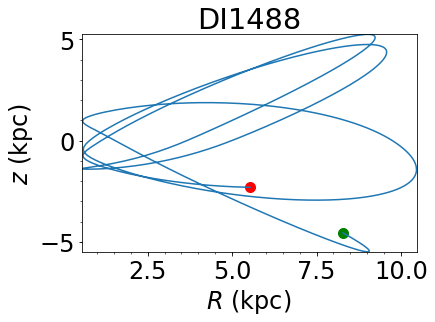

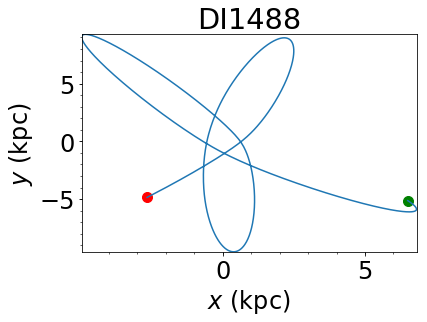

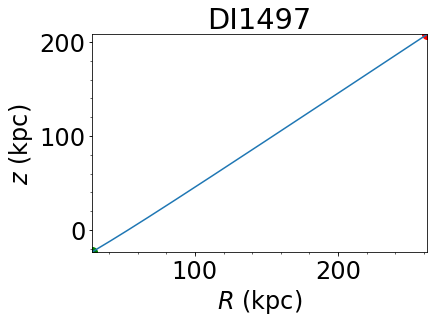

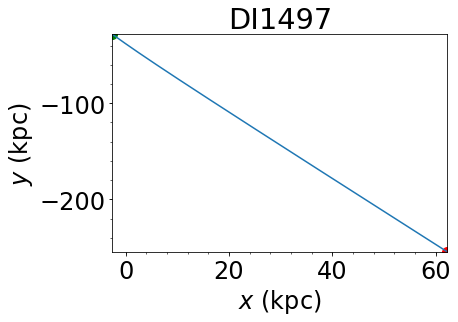

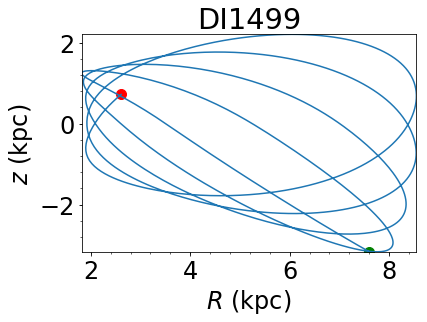

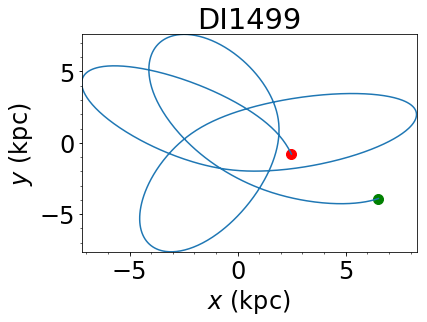

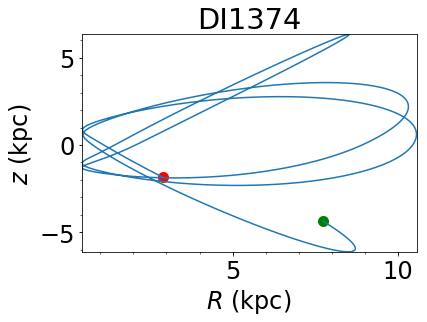

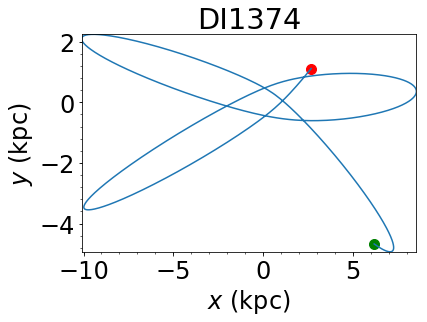

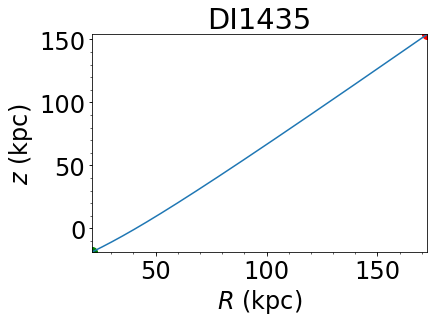

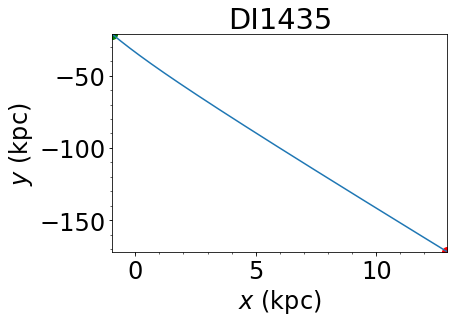

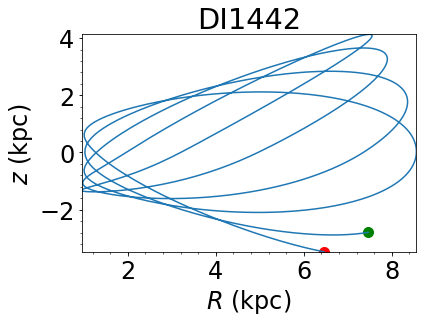

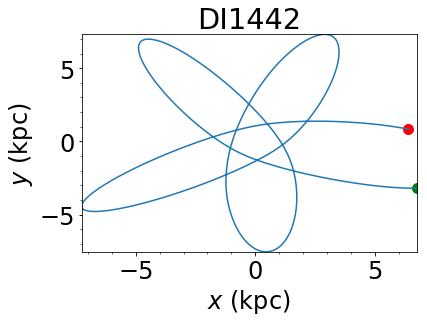

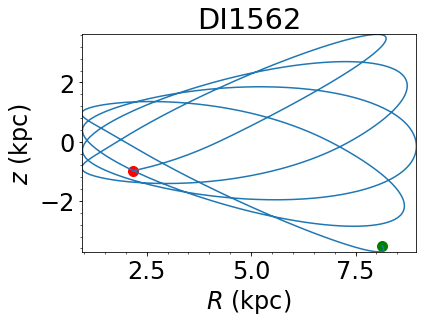

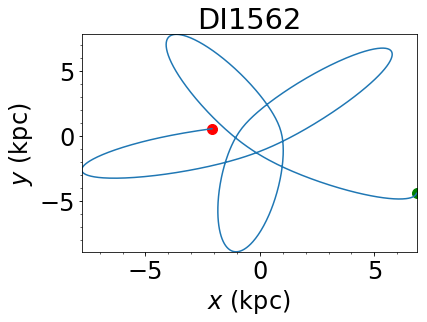

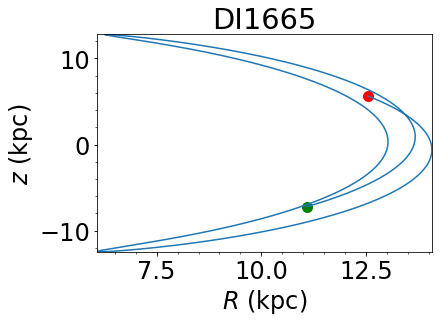

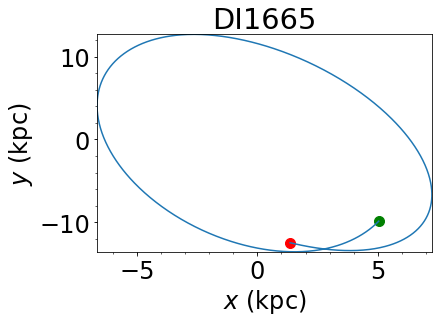

In [114]:
### Find The Orbits of the stars in group1

orbparams1 = []
orbR1 = []
orbPhi1 = []
orbZ1 = []
orbvR1 = []
orbvPhi1 = []
orbvZ1 = []
orbX1 = []
orbY1 = []
orbvX1 = []
orbvY1 = []


ts = np.linspace(0,500,1000)*u.Myr #Evolve for 500 Myr with 1000 timesteps or point every 500,000 years

for i in range(len(group1)):
    orb=Orbit(vxvv=[group1['RA'][i],group1['DEC'][i],np.reciprocal(group1['parallax'][i]+0.03),group1['pmra'][i],\
                      group1['pmdec'][i],group1['VHELIO'][i]],radec=True)
    orb.integrate(ts,MWPotential2014,method='rk4_c')
    orbparams1.append([group1['NAME'][i],orb.e(),orb.rperi(),orb.rap(),orb.zmax()])
    orbR1.append(orb.R(ts))
    orbPhi1.append(orb.phi(ts))
    orbZ1.append(orb.z(ts))
    orbvR1.append(orb.vR(ts))
    orbvPhi1.append(orb.vphi(ts))
    orbvZ1.append(orb.vz(ts))
    orbX1.append(orb.x(ts))
    orbY1.append(orb.y(ts))
    orbvX1.append(orb.vx(ts))
    orbvY1.append(orb.vy(ts))
    orb.plot(use_physical=True,label='{}'.format(group1['NAME'][i])) #use_physical=True
    plt.scatter(orbR1[i][0],orbZ1[i][0],c='g',s=100)
    plt.scatter(orbR1[i][-1],orbZ1[i][-1],c='r',s=100)
    plt.title('{}'.format(group1['NAME'][i]))
    orb.plot(d1='x',d2='y',use_physical=True,label='{}'.format(group1['NAME'][i]))
    plt.scatter(orbX1[i][0],orbY1[i][0],c='g',s=100)
    plt.scatter(orbX1[i][-1],orbY1[i][-1],c='r',s=100)
    plt.title('{}'.format(group1['NAME'][i]))



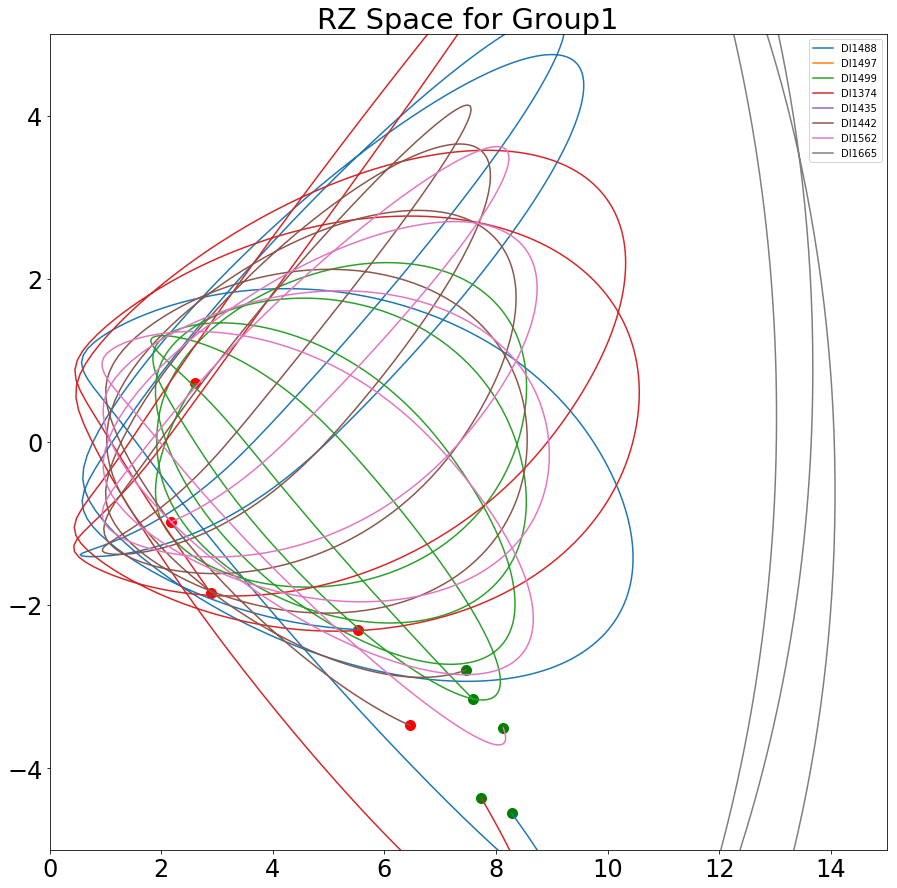

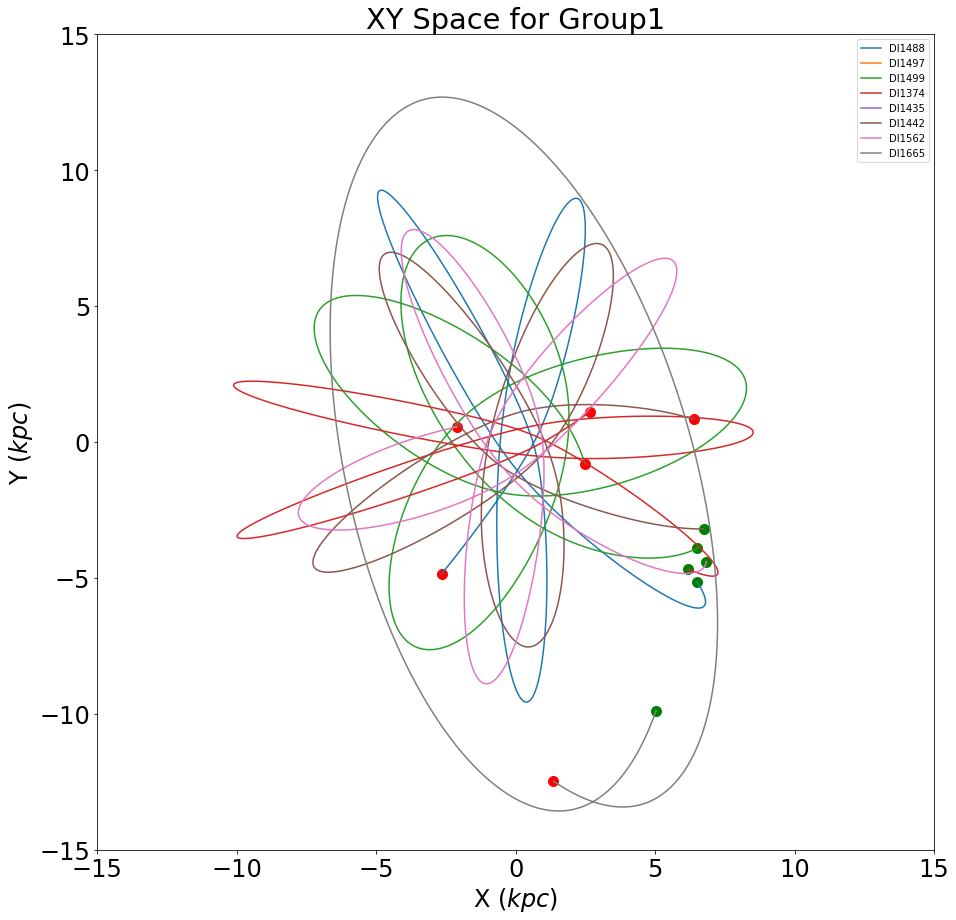

In [115]:
#Combine all orbit RZ and XY plots for group1
ts = np.linspace(0,500,1000)*u.Myr #Evolve for 500 Myr with 1000 timesteps or point every 500,000 years

plt.figure(figsize=(15,15))
for i in range(len(group1)):
    orb=Orbit(vxvv=[group1['RA'][i],group1['DEC'][i],np.reciprocal(group1['parallax'][i]+0.03),group1['pmra'][i],\
                    group1['pmdec'][i],group1['VHELIO'][i]],radec=True)
    orb.integrate(ts,MWPotential2014,method='rk4_c')
    orb.plot(use_physical=True,overplot=True,label='{}'.format(group1['NAME'][i]))
    plt.scatter(orbR1[i][0],orbZ1[i][0],c='g',s=100)
    plt.scatter(orbR1[i][-1],orbZ1[i][-1],c='r',s=100)
plt.legend(loc='upper right',fontsize=10)
plt.xlim(0,15)
plt.ylim(-5,5)
plt.title(r'RZ Space for Group1')
plt.show()

plt.figure(figsize=(15,15))
for i in range(len(group1)):
    orb=Orbit(vxvv=[group1['RA'][i],group1['DEC'][i],np.reciprocal(group1['parallax'][i]+0.03),group1['pmra'][i],\
                    group1['pmdec'][i],group1['VHELIO'][i]],radec=True)
    orb.integrate(ts,MWPotential2014,method='rk4_c')
    orb.plot(d1='x',d2='y',use_physical=True,overplot=True,label='{}'.format(group1['NAME'][i]))
    plt.scatter(orbX1[i][0],orbY1[i][0],c='g',s=100)
    plt.scatter(orbX1[i][-1],orbY1[i][-1],c='r',s=100)
plt.legend(loc='upper right',fontsize=10)
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.xlabel(r'X $(kpc)$')
plt.ylabel(r'Y $(kpc)$')
plt.title(r'XY Space for Group1')
plt.savefig('XYspace.pdf',bbox_inches='tight')
plt.show()

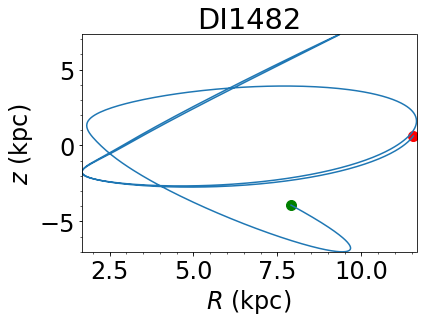

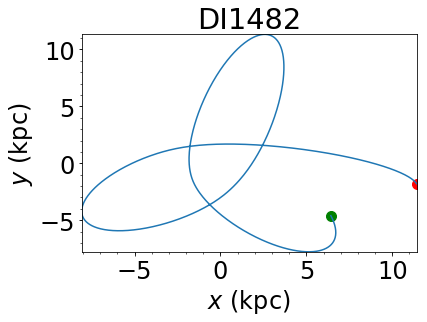

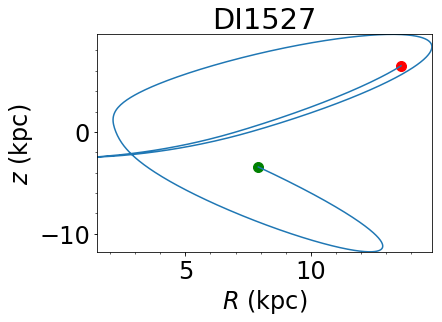

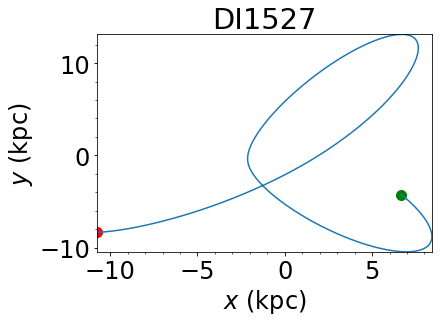

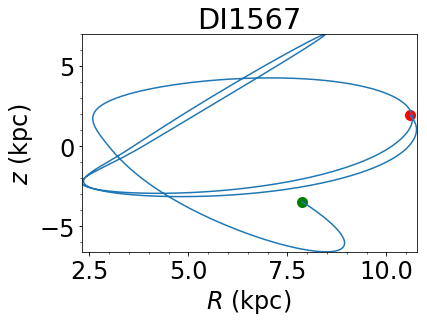

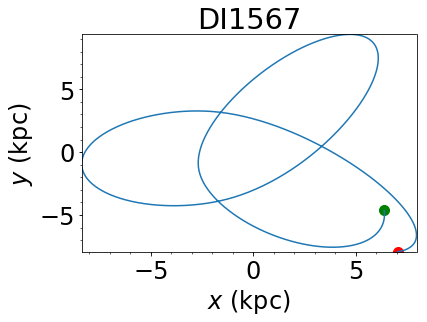

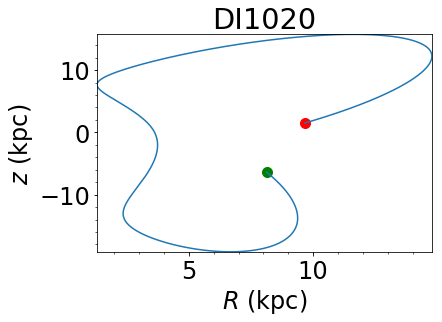

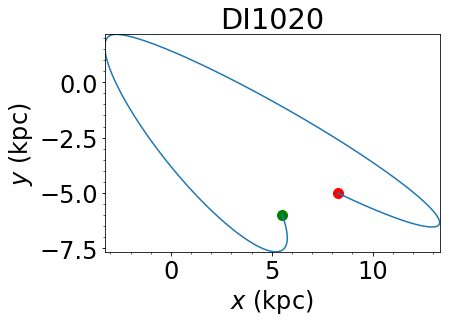

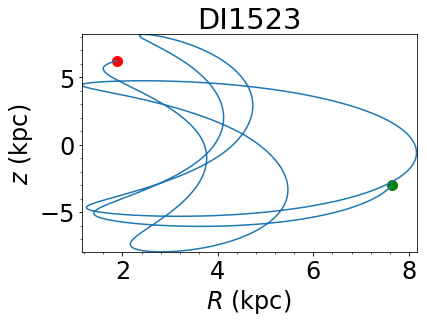

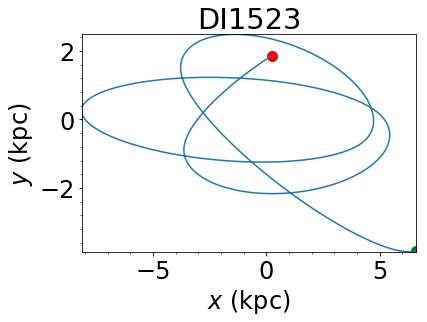

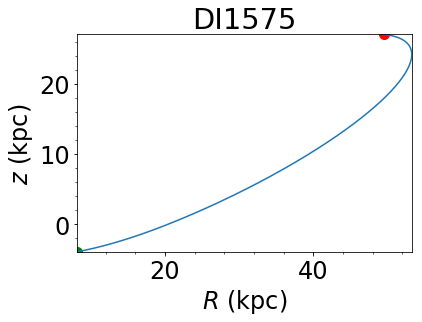

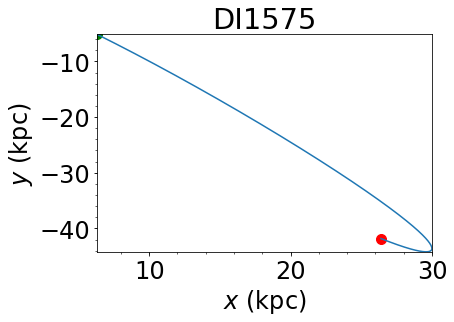

In [116]:
### Find The Orbits of the stars in group2

orbparams2 = []
orbR2 = []
orbPhi2 = []
orbZ2 = []
orbvR2 = []
orbvPhi2 = []
orbvZ2 = []
orbX2 = []
orbY2 = []
orbvX2 = []
orbvY2 = []


ts = np.linspace(0,500,1000)*u.Myr #Evolve for 500 Myr with 1000 timesteps or point every 500,000 years

for i in range(len(group2)):
    orb=Orbit(vxvv=[group2['RA'][i],group2['DEC'][i],np.reciprocal(group2['parallax'][i]+0.03),group2['pmra'][i],\
                      group2['pmdec'][i],group2['VHELIO'][i]],radec=True)
    orb.integrate(ts,MWPotential2014,method='rk4_c')
    orbparams2.append([group2['NAME'][i],orb.e(),orb.rperi(),orb.rap(),orb.zmax()])
    orbR2.append(orb.R(ts))
    orbPhi2.append(orb.phi(ts))
    orbZ2.append(orb.z(ts))
    orbvR2.append(orb.vR(ts))
    orbvPhi2.append(orb.vphi(ts))
    orbvZ2.append(orb.vz(ts))
    orbX2.append(orb.x(ts))
    orbY2.append(orb.y(ts))
    orbvX2.append(orb.vx(ts))
    orbvY2.append(orb.vy(ts))
    orb.plot(use_physical=True,label='{}'.format(group2['NAME'][i])) #use_physical=True
    plt.scatter(orbR2[i][0],orbZ2[i][0],c='g',s=100)
    plt.scatter(orbR2[i][-1],orbZ2[i][-1],c='r',s=100)
    plt.title('{}'.format(group2['NAME'][i]))
    orb.plot(d1='x',d2='y',use_physical=True,label='{}'.format(group2['NAME'][i]))
    plt.scatter(orbX2[i][0],orbY2[i][0],c='g',s=100)
    plt.scatter(orbX2[i][-1],orbY2[i][-1],c='r',s=100)
    plt.title('{}'.format(group2['NAME'][i]))

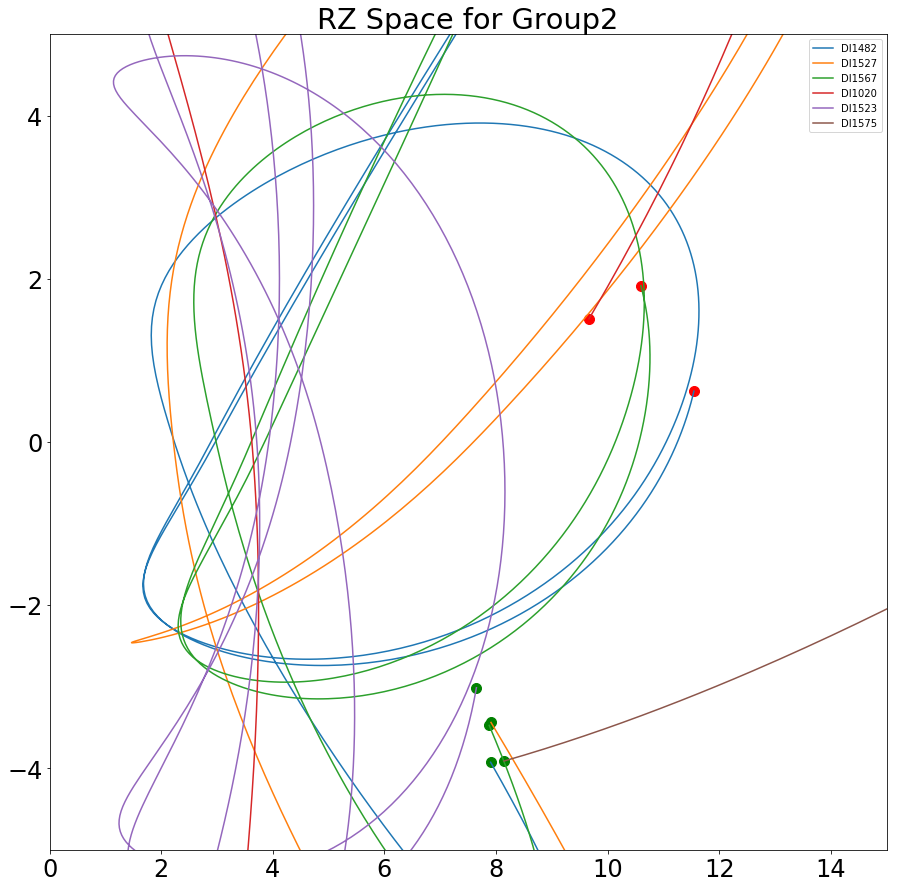

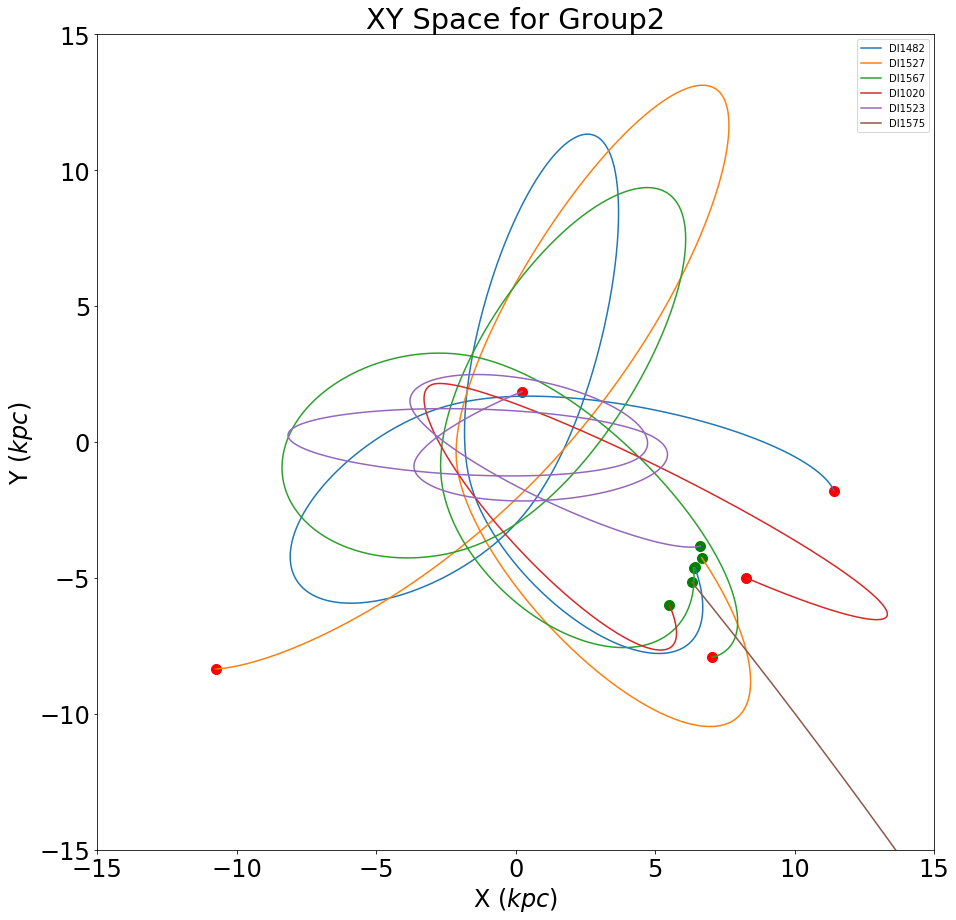

In [117]:
#Combine all orbit RZ and XY plots for group2
ts = np.linspace(0,500,1000)*u.Myr #Evolve for 500 Myr with 1000 timesteps or point every 500,000 years

plt.figure(figsize=(15,15))
for i in range(len(group2)):
    orb=Orbit(vxvv=[group2['RA'][i],group2['DEC'][i],np.reciprocal(group2['parallax'][i]+0.03),group2['pmra'][i],\
                    group2['pmdec'][i],group2['VHELIO'][i]],radec=True)
    orb.integrate(ts,MWPotential2014,method='rk4_c')
    orb.plot(use_physical=True,overplot=True,label='{}'.format(group2['NAME'][i]))
    plt.scatter(orbR2[i][0],orbZ2[i][0],c='g',s=100)
    plt.scatter(orbR2[i][-1],orbZ2[i][-1],c='r',s=100)
plt.legend(loc='upper right',fontsize=10)
plt.xlim(0,15)
plt.ylim(-5,5)
plt.title(r'RZ Space for Group2')
plt.show()

plt.figure(figsize=(15,15))
for i in range(len(group2)):
    orb=Orbit(vxvv=[group2['RA'][i],group2['DEC'][i],np.reciprocal(group2['parallax'][i]+0.03),group2['pmra'][i],\
                    group2['pmdec'][i],group2['VHELIO'][i]],radec=True)
    orb.integrate(ts,MWPotential2014,method='rk4_c')
    orb.plot(d1='x',d2='y',use_physical=True,overplot=True,label='{}'.format(group2['NAME'][i]))
    plt.scatter(orbX2[i][0],orbY2[i][0],c='g',s=100)
    plt.scatter(orbX2[i][-1],orbY2[i][-1],c='r',s=100)
plt.legend(loc='upper right',fontsize=10)
plt.xlim(-15,15)
plt.ylim(-15,15)
plt.xlabel(r'X $(kpc)$')
plt.ylabel(r'Y $(kpc)$')
plt.title(r'XY Space for Group2')
plt.savefig('XYspace.pdf',bbox_inches='tight')
plt.show()

In [118]:
print(group1['NAME'])
print(group1['parallax_over_error'])
'''Suspect stars do in fact correpsond to parallax_over_errors that are too small'''

 NAME 
------
DI1488
DI1497
DI1499
DI1374
DI1435
DI1442
DI1562
DI1665
parallax_over_error
-------------------
           2.858755
        -0.07153288
           3.977865
          4.4916215
        0.083756395
           6.352637
           6.792101
          1.2626429


'Suspect stars do in fact correpsond to parallax_over_errors that are too small'

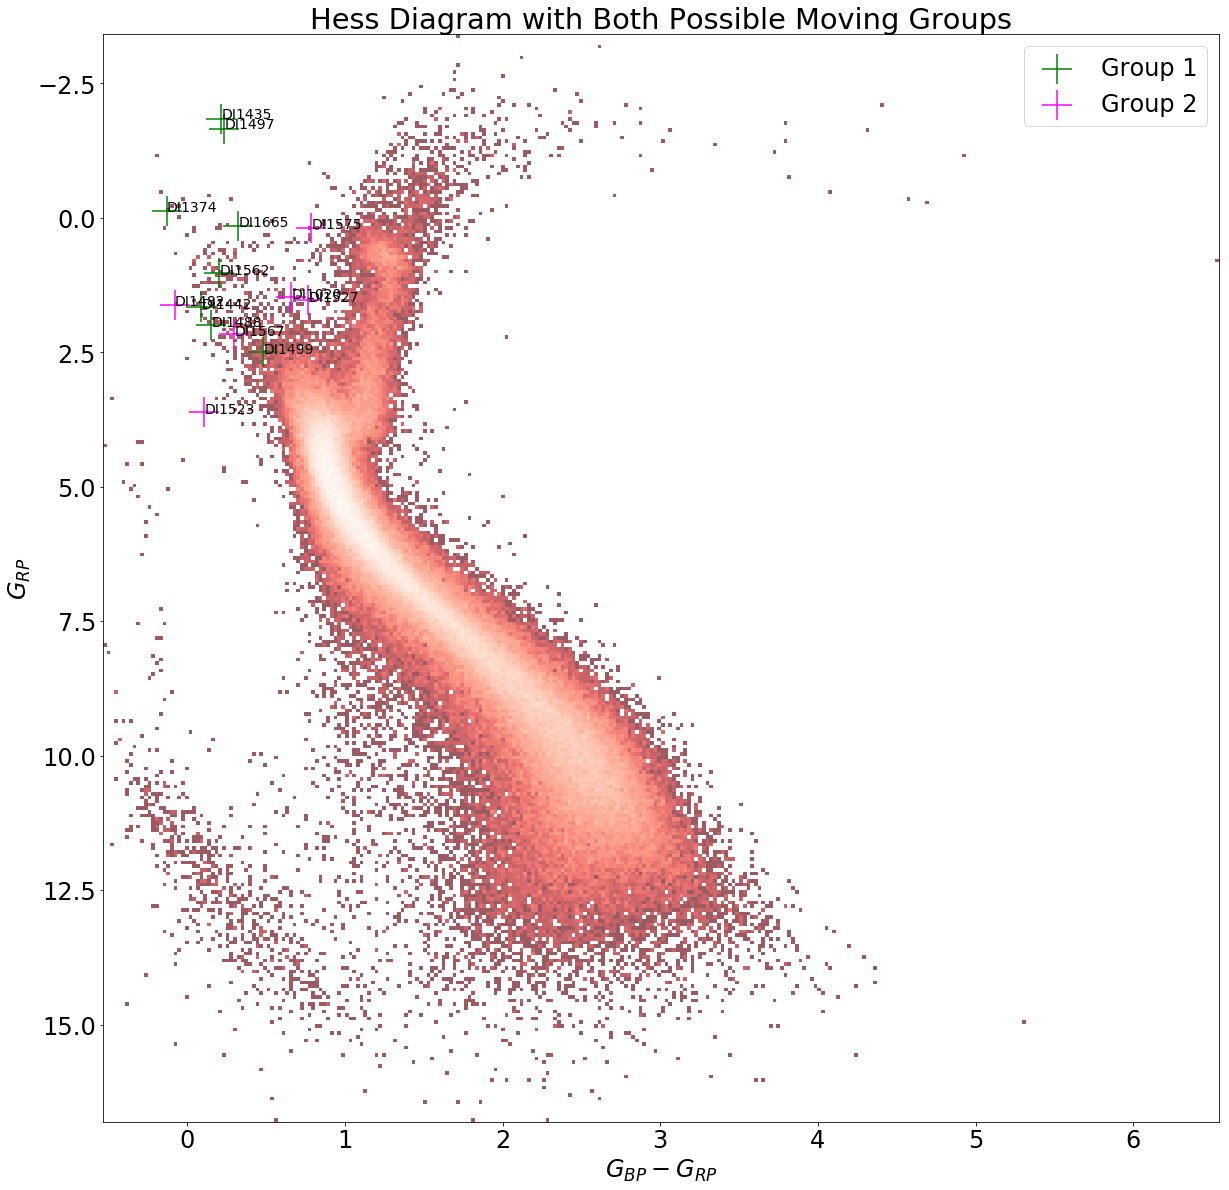

In [157]:
#Identify Steallar types from HR for large distances
    
import matplotlib.cm as cm
cmap1 = cm.get_cmap('Reds_r')
plt.figure(figsize=[20,20])
plt.imshow(np.log10(icrhess.statistic.T), origin='lower',extent=[icrhess.x_edge[0], icrhess.x_edge[-1], icrhess.y_edge[0], icrhess.y_edge[-1]],aspect='auto', interpolation='nearest', cmap=cmap1,alpha=0.65)
plt.scatter(group1['bp_rp'],absmags(group1['phot_g_mean_mag'],group1['parallax']+0.03,True),marker='+',s=900,c='green',label='Group 1')
plt.scatter(group2['bp_rp'],absmags(group2['phot_g_mean_mag'],group2['parallax']+0.03,True),marker='+',s=900,c='magenta',label='Group 2')
plt.legend()
plt.gca().invert_yaxis()
plt.xlabel(r'$G_{BP}-G_{RP}$')
plt.ylabel(r'$G_{RP}$')
plt.title(r'Hess Diagram with Both Possible Moving Groups')
for i in range(len(group1)):
    plt.text(group1['bp_rp'][i]*(1.0+0.01),absmags(group1['phot_g_mean_mag'],group1['parallax']+0.03,True)[i]*(1.0+0.01),group1['NAME'][i],fontsize=14)
for j in range(len(group2)):
    plt.text(group2['bp_rp'][j]*(1.0+0.01),absmags(group2['phot_g_mean_mag'],group2['parallax']+0.03,True)[j]*(1.0+0.01),group2['NAME'][j],fontsize=14)
plt.show()

In [138]:
### Angular Momentum for group1
#convert to galactocentric coordinates (x,y,z) and get galactocentric velocities and angular momentum
from astropy.coordinates import Distance

galactgroup1 = []
for i in range(len(group1)):
    cr = coord.ICRS(ra=group1['RA'][i]*u.degree, dec=group1['DEC'][i]*u.degree, \
                        distance=Distance(parallax=(group1['parallax'][i]+0.03)*u.mas,allow_negative=True),\
                        pm_ra_cosdec=group1['pmra'][i]*u.mas/u.yr,\
                        pm_dec=group1['pmdec'][i]*u.mas/u.yr,
                        radial_velocity=group1['VLSR'][i]*u.km/u.s)
    gcoor = cr.transform_to(coord.Galactocentric)
    galactgroup1.append(gcoor)
    
#Extract velocities  
xvelg1 = []
yvelg1 = []
zvelg1 = []

for i in range(len(galactgroup1)):
    xvelg1.append((galactgroup1[i].v_x).value)
    yvelg1.append((galactgroup1[i].v_y).value)
    zvelg1.append((galactgroup1[i].v_z).value)
    
xvelg1=np.squeeze(xvelg1)
yvelg1=np.squeeze(yvelg1)
zvelg1=np.squeeze(zvelg1)

#Extract position
xposg1 = []
yposg1 = []
zposg1 = []

for i in range(len(galactgroup1)):
    xposg1.append((galactgroup1[i].x).value*1/1000.) #note conversion from pc to kpc
    yposg1.append((galactgroup1[i].y).value*1/1000.)
    zposg1.append((galactgroup1[i].z).value*1/1000.)
    
xposg1=np.squeeze(xposg1)
yposg1=np.squeeze(yposg1)
zposg1=np.squeeze(zposg1)

#Calculate Angular momentum
sg1 = []
sxg1 = []
syg1 = []
szg1 = []
for i in range(len(galactgroup1)):
    radius = [xposg1[i],yposg1[i],zposg1[i]]
    velocity = [xvelg1[i],yvelg1[i],zvelg1[i]]
    sg1.append(np.cross(radius,velocity))
    sxg1.append(sg1[i][0])
    syg1.append(sg1[i][1])
    szg1.append(sg1[i][2])

In [200]:
allgal = []
for i in range(len(group1)):
    allgal.append(gal6d(group1['RA'][i],group1['DEC'][i],group1['parallax'][i]+0.03,group1['VLSR'][i],group1['pmra'][i],group1['pmdec'][i]))
       
newang = []
for j in range(len(allgal)):
    newang.append(np.cross(allgal[j][0],allgal[j][1]))
    
newangz = []
for l in range(len(newang)):
    newangz.append(newang[l][2])

In [212]:
di1374 = np.where(group1['NAME']=='DI1374')
#group1[di1374].show_in_browser(jsviewer=True)
np.reciprocal(group1[di1374]['parallax']+0.03)

6.668467616650211


In [213]:
newangz[np.squeeze(di1374)]

-1037.5908828951824

In [216]:
allgal[np.squeeze(di1374)]

array([[   4.05429194,   -2.32311868,    4.58754215],
       [-251.31171893, -111.92186938,   -1.90476576]])